In [6]:
import os
from dotenv import load_dotenv
from langchain_groq.chat_models import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_community.tools.tavily_search import TavilySearchResults
from pprint import pprint
from langchain_core.output_parsers import StrOutputParser
from langchain_openai.chat_models import ChatOpenAI
from langchain.agents.format_scratchpad import format_to_openai_function_messages
from langchain_core.runnables import RunnablePassthrough
from langchain.agents import OpenAIFunctionsAgent
from langchain.agents import AgentExecutor
from langchain.tools.render import render_text_description
from langchain.agents import self_ask_with_search

In [2]:
load_dotenv(override=True)

True

In [3]:
llm = ChatOpenAI(temperature=0, streaming=False, model="gpt-4-0125-preview")
ddg = DuckDuckGoSearchResults()
# tavily = TavilySearchResults()
llm.invoke("Hello")

NotFoundError: Error code: 404 - {'error': {'message': 'The model `gpt-4-0125-preview` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}

In [4]:
researcher_prompt_template = """
You are an Agriculture research specialist. Write 3 search queries

"""

## Fertilizer Application Recommendations

In [5]:
sample_data = {
    "crop": "Corn",
    "soil_type": "Sandy Loam",
    "soil_texture": "Fine",
    "soil_ph": 6.2,
    "pct_soil_moisture": 18,
    "soil_fertility": "Moderate",
    "irrigation": "Center Pivot",
    "fertilizer_type": "Granular",
    "frequency_of_application": "2 times per year",
    "pest_type": "Insect",
    "pests": "European Corn Borer",
    "diseases": "Northern Corn Leaf Blight",
    "weed_control_method": "Chemical",
    "frequency_of_weed_control": "3 times per year",
    "wind": "8 mph",
    "humidity": "65%",
    "temperature": 28,
    "status": "Partly Cloudy",
    "rain": 0.2,
    "heat_index": 32,
    "clouds": 40,
    "pressure": 1018,
}

sample_data

{'crop': 'Corn',
 'soil_type': 'Sandy Loam',
 'soil_texture': 'Fine',
 'soil_ph': 6.2,
 'pct_soil_moisture': 18,
 'soil_fertility': 'Moderate',
 'irrigation': 'Center Pivot',
 'fertilizer_type': 'Granular',
 'frequency_of_application': '2 times per year',
 'pest_type': 'Insect',
 'pests': 'European Corn Borer',
 'diseases': 'Northern Corn Leaf Blight',
 'weed_control_method': 'Chemical',
 'frequency_of_weed_control': '3 times per year',
 'wind': '8 mph',
 'humidity': '65%',
 'temperature': 28,
 'status': 'Partly Cloudy',
 'rain': 0.2,
 'heat_index': 32,
 'clouds': 40,
 'pressure': 1018}

In [2]:
from langchain import hub
from langchain.agents import AgentExecutor, create_self_ask_with_search_agent
from langchain_community.llms import Fireworks
from langchain_community.tools.tavily_search import TavilyAnswer


# Get the prompt to use - you can modify this!
prompt = hub.pull("hwchase17/self-ask-with-search")
prompt

PromptTemplate(input_variables=['agent_scratchpad', 'input'], metadata={'lc_hub_owner': 'hwchase17', 'lc_hub_repo': 'self-ask-with-search', 'lc_hub_commit_hash': '9ef33d1fc82608bdfaa88b3757306ec4f22511b736cb267b1737616641dac0cc'}, template='Question: Who lived longer, Muhammad Ali or Alan Turing?\nAre follow up questions needed here: Yes.\nFollow up: How old was Muhammad Ali when he died?\nIntermediate answer: Muhammad Ali was 74 years old when he died.\nFollow up: How old was Alan Turing when he died?\nIntermediate answer: Alan Turing was 41 years old when he died.\nSo the final answer is: Muhammad Ali\n\nQuestion: When was the founder of craigslist born?\nAre follow up questions needed here: Yes.\nFollow up: Who was the founder of craigslist?\nIntermediate answer: Craigslist was founded by Craig Newmark.\nFollow up: When was Craig Newmark born?\nIntermediate answer: Craig Newmark was born on December 6, 1952.\nSo the final answer is: December 6, 1952\n\nQuestion: Who was the maternal

In [5]:
"""Question: Who lived longer, Muhammad Ali or Alan Turing?
Are follow up questions needed here: Yes.
Follow up: How old was Muhammad Ali when he died?
Intermediate answer: Muhammad Ali was 74 years old when he died.
Follow up: How old was Alan Turing when he died?
Intermediate answer: Alan Turing was 41 years old when he died.
So the final answer is: Muhammad Ali"""


"""
Task: Using this information, generate recommendations for the name(s) of fertilizers to be applied, including application rates, application method and reasonings for your recommendation.
Are follow up questions needed here: Yes.
Follow up: What is the recommended fertilizer for corn?

"""

Question: Who lived longer, Muhammad Ali or Alan Turing?
Are follow up questions needed here: Yes.
Follow up: How old was Muhammad Ali when he died?
Intermediate answer: Muhammad Ali was 74 years old when he died.
Follow up: How old was Alan Turing when he died?
Intermediate answer: Alan Turing was 41 years old when he died.
So the final answer is: Muhammad Ali

Question: When was the founder of craigslist born?
Are follow up questions needed here: Yes.
Follow up: Who was the founder of craigslist?
Intermediate answer: Craigslist was founded by Craig Newmark.
Follow up: When was Craig Newmark born?
Intermediate answer: Craig Newmark was born on December 6, 1952.
So the final answer is: December 6, 1952

Question: Who was the maternal grandfather of George Washington?
Are follow up questions needed here: Yes.
Follow up: Who was the mother of George Washington?
Intermediate answer: The mother of George Washington was Mary Ball Washington.
Follow up: Who was the father of Mary Ball Washin

In [5]:
from schemas.ai_recommendations import FertilizerSchema

fert_prompt_template = (
    "You are an Agriculture Specialist that analyzes a farmer's farm soil and weather data"
    "and then provide tailored recommendations for fertilizer application based on crop grown.\n"
    "Your fertizer recommendations should have the name(s) of fertilizers"
    "the farmer should apply, application timings and rates, application method and reasonings for your recommendation.\n\n"
    """
Crop
----
Crop grown: {crop}

Soil Data
---------
soil type: {soil_type}
soil ph: {soil_ph}
soil moisture: {pct_soil_moisture}

Weather data
-----------
wind: {wind}
humidity: {humidity}
temperature: {temperature}
heat_index: {heat_index}
pressure: {pressure}

You have access to a search engine

{agent_scratchpad}
    """
)

sample_data.update({"intermediate_steps": []})

fert_prompt = ChatPromptTemplate.from_template(fert_prompt_template)
fertilizer_chain = (
    RunnablePassthrough.assign(
        agent_scratchpad=lambda x: format_to_openai_function_messages(
            x["intermediate_steps"]
        )
    )
    | fert_prompt
    | llm.bind_tools(tools=[ddg])
)
print(fertilizer_chain.invoke(sample_data))

content='' additional_kwargs={'tool_calls': [{'id': 'call_S4jhgvY41ajsPoco0DxXNccZ', 'function': {'arguments': '{"query":"best fertilizer application for corn in sandy loam soil"}', 'name': 'duckduckgo_results_json'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 225, 'total_tokens': 252}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': 'fp_b28b39ffa8', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-717077b6-eb57-4fd8-a5f9-41bc632f9586-0'


In [8]:
fert_agent = create_openai_functions_agent(llm=llm, tools=[ddg], prompt=fert_prompt)
executor = AgentExecutor(agent=fert_agent, tools=[ddg], verbose=True)
results = executor.invoke(sample_data)

NameError: name 'create_openai_functions_agent' is not defined

In [17]:
prompt = ChatPromptTemplate.from_messages(
    messages=[
        (
            "system",
            (
                "You are an Agriculture Specialist that analyzes a farmer's farm soil and weather data "
                "and then provide tailored recommendations for fertilizer application based on crop grown.\n"
                "Your fertilizer recommendations should have the name(s) of fertilizers the farmer should apply, "
                "application timings and rates, application method and reasonings for your recommendation.\n\n"
                "The crop grown is {crop}, the soil type is {soil_type}, the soil pH is {soil_ph}, and "
                "the soil moisture is {pct_soil_moisture}. The weather data includes wind at {wind}, humidity at {humidity}, "
                "temperature of {temperature}, heat index of {heat_index}, and pressure at {pressure}. \n\n"
            ),
        ),
        (
            "human",
            (
                "Task: Using this information, generate recommendations for the name(s) of fertilizers to be applied, including"
                "application timings and rates, application method and reasonings for your recommendation."
            ),
        ),
    ]
)

print(prompt.messages[1].prompt.template)

Task: Using this information, generate recommendations for the name(s) of fertilizers to be applied, includingapplication timings and rates, application method and reasonings for your recommendation.


In [12]:
from schemas.ai_recommendations import PestControlMeasures, DiseaseControlMeasures
from langchain.pydantic_v1 import BaseModel, Field
from typing import List, Dict, Any, Optional


pest_prompt_template = (
    "You are a Pest Management Specialist that analyzes a farmer's data, crop information and weather data and then"
    "provide structure, tailored recommendations for pest control measures that the farmer should implement.\n"
    "Your pest control recommendations should include the specific pesticide(s) the farmer should use, their"
    "the application rates and timings and each stage of crop growth, and the reasoning behind your recommendations."
    """

Crop
----
Crop grown: {crop}

Weather data
-----------
wind: {wind}
humidity: {humidity}
temperature: {temperature}
heat_index: {heat_index}
pressure: {pressure}

Pests
-----------------
pests: {pests}
"""
)


pest_prompt = ChatPromptTemplate.from_template(pest_prompt_template)
pest_chain = pest_prompt | llm.with_structured_output(schema=PestControlMeasures)

In [13]:
output = pest_chain.invoke(sample_data)

NotFoundError: Error code: 404 - {'error': {'message': 'The model `gpt-4-0613` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}

In [9]:
output.dict()

{'pesticides': ['Bacillus thuringiensis', 'Spinosad'],
 'application_method': None,
 'application_rates_and_timings': [{'stage': 'Early vegetative stage',
   'rate': '2 lbs/acre',
   'timing': 'Apply when pests are first observed'}],
 'safety_precautions': None,
 'reapplication_frequency': None,
 'reasoning': 'Bacillus thuringiensis and Spinosad are effective against European Corn Borer. Bacillus thuringiensis is a biological pesticide that targets the larvae of the European Corn Borer, while Spinosad is a natural insecticide that is also effective against this pest. Applying these pesticides at the early vegetative stage helps control the pest population before it causes significant damage to the corn crop.'}

## Diseases Control Recommendations

In [ ]:
disease_prompt_template = (
    "You are a Plant Pathologist that analyzes a farmer's data, crop information and weather data and then"
    "provide structure, tailored recommendations for disease control measures that the farmer should implement.\n"
    "Your disease control recommendations should include the specific fungicide(s) the farmer should use, their"
    "the application rates and timings and each stage of crop growth, and the reasoning behind your recommendations."
    """

Crop
----
Crop grown: {crop}

Weather data
-----------
wind: {wind}
humidity: {humidity}
temperature: {temperature}
heat_index: {heat_index}
pressure: {pressure}

Diseases
-----------------
diseases: {diseases}
    """
)

disease_prompt = ChatPromptTemplate.from_template(disease_prompt_template)
disease_chain = disease_prompt | llm.with_structured_output(schema=PestControlMeasure)

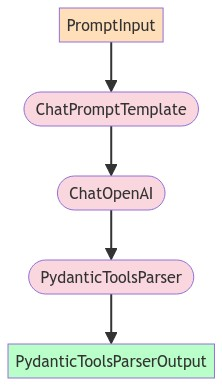

In [56]:
from io import BytesIO
from PIL import Image

Image.open(BytesIO(pest_chain.get_graph().draw_mermaid_png()))